In [1]:
from sys import path
if '..' not in path:
    path.insert(0, '..')

In [2]:
from _library.utils import SYSTEM_NAMES_UNIGE,SYSTEM_NAMES_FULL, load_datasets
from os import path, makedirs
from scipy.stats import stats

In [3]:
import _library.diagnostic_utils as diagnostic_utils
import _library.fault_utils as fault_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from datetime import datetime, timedelta, timezone

In [5]:
%cd /mnt/data/vieri/projects/SAMPLE/

/mnt/data/vieri/projects/SAMPLE


# A) The PV system

## A.1) Selecting the PV System

In [6]:
print(SYSTEM_NAMES_UNIGE)
# --- 0 ---------- 1 ---------- 2 ----- 3 ------ 4 --------- 5 -------- 6 --------- 7 ----

['FV', 'Q05_FV']


In [7]:
# N.B. we have data only for FV system
system_name = SYSTEM_NAMES_UNIGE[0]
print("PV SYSTEM -->", system_name)

PV SYSTEM --> FV


## A.2) Retrieve the Nominal Power of the PV system

In [8]:
inv_names = [system_name]
nominal_power = diagnostic_utils.load_PV_nominal_power(system_name)
inverter_nominal_power = nominal_power / len(inv_names)
beta = diagnostic_utils.load_PV_params(system_name)
print(f"[{system_name}] PV Nominal Power:   {nominal_power} kWp")
print(f"[{system_name}] It has {len(inv_names)} inverters: {inverter_nominal_power} kWp/inverter")

[FV] PV Nominal Power:   80 kWp
[FV] It has 1 inverters: 80.0 kWp/inverter


In [9]:
beta = diagnostic_utils.load_PV_params(system_name)

## A.3) Data wrangling

In [10]:
def maps_connector_data_wrangler():
    df = pd.DataFrame(columns = ["Irradiance (W/mq)", "Panel Temp 1", "Panel Temp 2"])

    data_type = "RADIATION"
    print("Reading " + data_type + " data of masp connector" + " ...")
    radiation = pd.read_csv("data/unige/pv1_maps_connector_data/pv1_panel_solar_rad.csv")
    radiation.columns = ['timestamp', 'Irradiance (W/mq)']
    radiation['timestamp'] = pd.to_datetime(radiation.timestamp)

    time_grouper = pd.Grouper(freq="1h")

    radiation = radiation.set_index('timestamp')
    data = radiation.groupby(time_grouper)['Irradiance (W/mq)'].mean()
    radiation = pd.DataFrame(data)
    radiation.index = radiation.index + timedelta(hours=1)

    data_type = "Temperature 1"
    print("Reading " + data_type +  " data of maps connector" + " ...")
    temperature1 = pd.read_csv("data/unige/pv1_maps_connector_data/pv1_panel_temp1.csv")
    temperature1.columns = ['timestamp', 'Panel Temp 1']
    temperature1['timestamp'] = pd.to_datetime(temperature1.timestamp)

    temperature1 = temperature1.set_index('timestamp')
    data = temperature1.groupby(time_grouper)['Panel Temp 1'].mean()
    temperature1 = pd.DataFrame(data)
    temperature1.index = temperature1.index + timedelta(hours=1)

    data_type = "Temperature 2"
    print("Reading " + data_type +  " data of maps connector" + " ...")
    temperature2 = pd.read_csv("data/unige/pv1_maps_connector_data/pv1_panel_temp2.csv")
    temperature2.columns = ['timestamp', 'Panel Temp 2']
    temperature2['timestamp'] = pd.to_datetime(temperature2.timestamp)

    temperature2 = temperature2.set_index('timestamp')
    data = temperature2.groupby(time_grouper)['Panel Temp 2'].mean()
    temperature2 = pd.DataFrame(data)
    temperature2.index = temperature2.index + timedelta(hours=1)

    data_type = "active_power"
    print("Reading " + data_type + " data of maps connector" + " ...")
    active_power = pd.read_csv("data/unige/pv1_maps_connector_data/pv1_active_power.csv")
    active_power.columns = ['timestamp', 'active_power']
    active_power['timestamp'] = pd.to_datetime(active_power.timestamp)

    active_power = active_power.set_index('timestamp')
    data = active_power['active_power'].groupby([pd.Grouper(freq='h')]).sum()
    ap = pd.DataFrame(data)

    ap['active_power_count'] = active_power['active_power'].groupby([pd.Grouper(freq='h')]).count().values
    ap["Generated Energy (kWh)"] = ap['active_power'] / ap['active_power_count']
    ap.loc[ap[ap["Generated Energy (kWh)"] < 0].index, "Generated Energy (kWh)"] = 0
        
    gen_energy = pd.DataFrame(ap.iloc[:,-1])
    df = df.append(radiation.join(temperature1).join(temperature2).join(gen_energy))
    
    return df, radiation, temperature1, temperature2, gen_energy

In [11]:
df, maps_radiation, maps_temperature1, maps_temperature2, maps_gen_energy = maps_connector_data_wrangler()

Reading RADIATION data of masp connector ...
Reading Temperature 1 data of maps connector ...
Reading Temperature 2 data of maps connector ...
Reading active_power data of maps connector ...


/tmp/ipykernel_16379/4181230160.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(radiation.join(temperature1).join(temperature2).join(gen_energy))


## A.3 bis) Visualize data

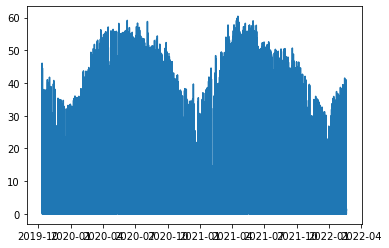

In [12]:
plt.plot(maps_gen_energy)

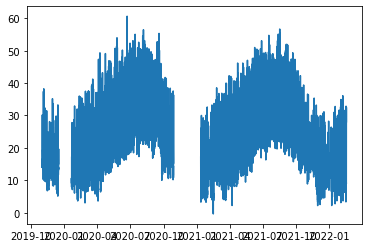

In [13]:
plt.plot(maps_temperature1)

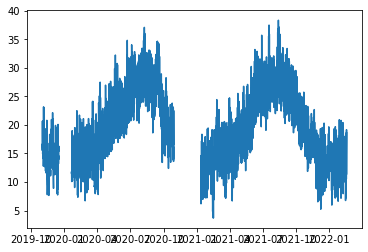

In [14]:
plt.plot(maps_temperature2)

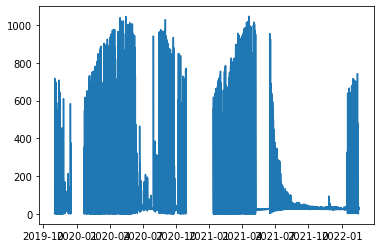

In [15]:
plt.plot(maps_radiation)

## A.4) Carry out some transformation to the dataset
1. Setting the **datetime column as index**.
2. **Computing the Generated Energy (kWh)** for each observation using the active power.
3. **Discarding problematic periods** (i.e., corrupted data)
4. fitting missing values

In [16]:
pd.set_option('display.float_format', lambda value: '%.3f' % value)
dt_col_name = "Date/Time"

# a) Set the datatime as index 
#    df.set_index(keys = df[dt_col_name], inplace = True)
#    df.drop(columns = dt_col_name, inplace = True)
#    print("a) Setting the datetime column as index.\n")

# b) Compute the E. totale (kWh) for the observations
df["E. totale (kWh)"] = df['Generated Energy (kWh)'].cumsum()
print("b) Compute the E. totale (kWh) for each observation .\n")

duplicated_ts = df[df.index.duplicated()].index
df.drop(index = duplicated_ts, inplace= True)
if len(duplicated_ts) > 0:
    print(f"d) Dropped some artefacts (i.e., {len(duplicated_ts)} duplicated obs.)\n")

b) Compute the E. totale (kWh) for each observation .



In [17]:
column_names = ['Irradiance (W/mq)', 'Panel Temp 1', 'Panel Temp 2','Generated Energy (kWh)']

In [18]:
def fit_missing_values(df,column_names, yearly_window = 7, local_window=7):
    
    for column_name in column_names:
        nan_indexes = df[df[column_name].isna()].index
#        if column_name == 'Irradiance (W/mq)':
#            for idx in nan_indexes:
#                df.at[idx,column_name] = df[idx-timedelta(days=local_window)::24].head(local_window).rolling(window = str(local_window)+'d').mean()[column_name][-1]
        
#        else:
        for idx in nan_indexes:
            if idx-timedelta(days=yearly_window+365-1) in df.index and not np.isnan(df.loc[idx-timedelta(days=yearly_window+365-1),column_name]):
                df.at[idx,column_name] = df[idx-timedelta(days=yearly_window+365-1)::24].head(yearly_window).rolling(window = str(yearly_window)+'d').mean()[column_name][-1]
            else:
                df.at[idx,column_name] = df[idx-timedelta(days=local_window)::24].head(local_window).rolling(window = str(local_window)+'d').mean()[column_name][-1]
    return df

In [19]:
df = fit_missing_values(df,column_names)

### quality check

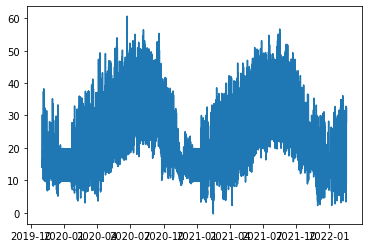

In [20]:
plt.plot(df['Panel Temp 1'])

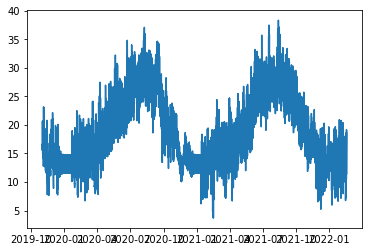

In [21]:
plt.plot(df['Panel Temp 2'])

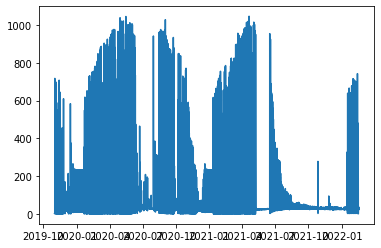

In [22]:
plt.plot(df['Irradiance (W/mq)'])

### A.5) choose which KPI to use

In [23]:
##### choose which temp to use
possible_temp = ['Panel Temp 1', 'Panel Temp 2']
temp = possible_temp[0]

df = df.rename(columns={temp: "Panel Temp (°C)"})
columns = ['Irradiance (W/mq)', 'Panel Temp (°C)', 'Generated Energy (kWh)',"E. totale (kWh)"]
df = df[columns]

In [24]:
KPI_to_compute_options = ['PR', 'PR_with_temp_correction']

print('-'*30, 'set the type of KPI to compute', '-'*30)
#### choose the KPI to compute

KPI_to_compute = KPI_to_compute_options[1]
print(KPI_to_compute)

inv_data = {}

if KPI_to_compute == 'PR':
    df = df[['Irradiance (W/mq)','Generated Energy (kWh)', "E. totale (kWh)"]].dropna()
if KPI_to_compute == 'PR_with_temp_correction':
    df = df.dropna()

------------------------------ set the type of KPI to compute ------------------------------
PR_with_temp_correction


# B) Outlier correction

## *Find and Fix the outliers*: Negative values for the variable 'Generated Energy'

In [25]:
# 0) Load the dataset
simplifed_df = df[["E. totale (kWh)", "Generated Energy (kWh)"]]

# 1) Find the outliers (TYPE A: Negative Generated Energy)
neg_cond = simplifed_df["Generated Energy (kWh)"] < - 0.00001 #? --> SINCE: -0.0
negative_generated_energy = simplifed_df[neg_cond]

if len(negative_generated_energy) != 0:
    print(f"OUTLIER (Type A): There are {len(negative_generated_energy)} observations "\
          f"({round((len(negative_generated_energy)/len(simplifed_df))*100, 2)} %) with a NEGATIVE VALUE for "\
          f"the generated energy (kWh)")

    # Perform the outlier corrrection 
    diagnostic_utils.neg_outlier_correction(df, negative_generated_energy.index)

else:
    print("OUTLIER (Type A): That's good. No negative values have been found!")

OUTLIER (Type A): That's good. No negative values have been found!


# C) Dealing with missing houlry observations 
## STATEGY: Subtract the increment detected during the missing observations

In [26]:
timestamps = df.index.tolist()

# Detect gaps
time_deltas = np.diff(timestamps)
idk_problematic_obs = [(idk_obs, delta.components[1]) for idk_obs, delta in enumerate(time_deltas) if delta.components[1] > 1]

if len(idk_problematic_obs) == 0:
    print("OUTLIER (Type B): That's good. No problematic gaps have been found!")

for counter, (idk_obs, delta) in enumerate(idk_problematic_obs): 

    # Retrieve the previous and next value
    window_df = df.loc[df.index[idk_obs]:df.index[idk_obs + 1], "E. totale (kWh)"]
    obs_value = window_df.iloc[0]
    next_value = window_df.iloc[1]
    ts_next_obs = window_df.index[1]

    # Detect whethere there has been an increase in the cumulative variable 
    increase = round(np.abs(next_value - obs_value), 0)
    if increase > 0:
        print(f"\nPROBLEMATIC OBSERVATION: {counter + 1}/{len(idk_problematic_obs)}: "\
              f"{df.index[idk_obs].strftime('%Y-%m-%d (%H:%M)')}\n" + 60 * "-")
        print(f"[OBSERVATION]   {window_df.index[0].strftime('%H:%M')}: {round(obs_value, 2)} kWh")
        print(f"[NEXT OBS.]     {window_df.index[1].strftime('%H:%M')}: {round(next_value, 2)} kWh ")
        print(f"\n--> DELTA:  {delta} hours \n--> INCREASE: {increase} kWh\n")

        print('STAT 1: Subtract the "extra" generated energy from all the counters of the upcoming observations\n' 
              + "-" * 95)
        print(f"[BEFORE] Last obs. {df.index[-1]} --> {df['E. totale (kWh)'].iloc[-1]} kWh")

#            df.loc[ts_next_obs: , "E. totale (kWh)"] -= increase

        print(f"[AFTER]  Last obs. {df.index[-1]} --> {df['E. totale (kWh)'].iloc[-1]} kWh (-{increase} kWh)") 


PROBLEMATIC OBSERVATION: 1/19: 2020-01-27 (21:00)
------------------------------------------------------------
[OBSERVATION]   21:00: 8958.11 kWh
[NEXT OBS.]     14:00: 8971.68 kWh 

--> DELTA:  17 hours 
--> INCREASE: 14.0 kWh

STAT 1: Subtract the "extra" generated energy from all the counters of the upcoming observations
-----------------------------------------------------------------------------------------------
[BEFORE] Last obs. 2022-02-17 12:00:00+00:00 --> 181814.12404853394 kWh
[AFTER]  Last obs. 2022-02-17 12:00:00+00:00 --> 181814.12404853394 kWh (-14.0 kWh)

PROBLEMATIC OBSERVATION: 2/19: 2020-05-09 (05:00)
------------------------------------------------------------
[OBSERVATION]   05:00: 33673.08 kWh
[NEXT OBS.]     07:00: 33675.68 kWh 

--> DELTA:  2 hours 
--> INCREASE: 3.0 kWh

STAT 1: Subtract the "extra" generated energy from all the counters of the upcoming observations
----------------------------------------------------------------------------------------------

# D) Perfomance Ratio (PR)

## D.1) Set Sliding window [months]
1. Number of months
2. Cumulative [-1]

In [27]:
sliding_window = 1

## D.2) Compute the *daily* Perfomance Ratio using a sliding window

In [28]:
verbose = False

In [29]:
inv_perfomance_ratio = dict()

# Isolate the dates
all_df_dates = sorted(set(df.index.date))
print(f"DATE AVAIABLE: {len(all_df_dates)}")
print(f"SELECTED PERIOD: {sliding_window} month(s)\n" +"-" * 40)

#display(df['2019-09-29':].head(50))

daily_perfomance_ratio = dict()
for idk, day in enumerate(all_df_dates):
    daily_ratio = diagnostic_utils.compute_perfomance_ratios(df, all_df_dates, day, sliding_window, 
                                                             inverter_nominal_power, verbose)

    # Try to use the previous KPI value (if available) in case of None value
    if daily_ratio == None:
        prev_day = all_df_dates[idk - 1]

        if str(prev_day) in daily_perfomance_ratio.keys():
            prev_kpi = daily_perfomance_ratio[str(prev_day)]
            daily_ratio = prev_kpi

            #print(f"[FIXED] Replaced the missing value with: {prev_day} "\
                  #f"--> KPI: {round(prev_kpi['Perfomance Ratio (%)'], 2)} %")

    # Save the value only if it's available
    if daily_ratio:
        daily_perfomance_ratio[str(day)] = daily_ratio

# Create and save a dataframe for each inverter
perfomance_ratio_df = pd.DataFrame.from_dict(daily_perfomance_ratio, orient = "index")

# Carry out some transformation
perfomance_ratio_df["Generated energy (kWh)"] = perfomance_ratio_df["Generated energy (kWh)"] / 10 ** 3
perfomance_ratio_df["Summed Solar Irradiance (Wh/mq)"] = perfomance_ratio_df["Summed Solar Irradiance (Wh/mq)"] / 10 ** 3
perfomance_ratio_df.rename(columns = {"Generated energy (kWh)": "Generated energy (MWh)",
                                      "Summed Solar Irradiance (Wh/mq)" : "Summed Solar Irradiance (kWh/mq)"}, 
                           inplace = True)
#display(perfomance_ratio_df)

#x = inv_perfomance_ratio[inv_names[0]].head(50)
#display(x)

DATE AVAIABLE: 835
SELECTED PERIOD: 1 month(s)
----------------------------------------


../_library/diagnostic_utils.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_sliding_window["Irradiance (Wh/mq)"] = obs_sliding_window["Irradiance (W/mq)"] * 1 # hour
../_library/diagnostic_utils.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_sliding_window["Irradiance (Wh/mq)"] = obs_sliding_window["Irradiance (W/mq)"] * 1 # hour
../_library/diagnostic_utils.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

## D.3) Visualize potential problematic ratios

In [30]:
pr_col_name = "Perfomance Ratio (%)"

# ISSUE: Perfomance Ratio values excedding 100%
cond = perfomance_ratio_df[pr_col_name] > 100
invalid_scores = perfomance_ratio_df.loc[cond, :]
if len(invalid_scores) > 0:
    print(f"ISSUE: There are {len(invalid_scores)} observations ({round((len(invalid_scores)/len(perfomance_ratio_df))*100, 2)} %) "\
          "which have their PERFOMANCE RATIO EXCEEDING 100%\n" + "-" * 96)

    verbose = True
    for idk, outlier_ts in enumerate(invalid_scores.index): #[:50]
        print(f"\n\tOBSERVATION ({idk + 1}/{len(invalid_scores)}): {outlier_ts}\n\t" + "-" * 41)

        observation = invalid_scores.loc[outlier_ts, :]

        if verbose:
            for col_name, value in observation.to_dict().items():
                name_parts = col_name.split("(")
                if len(name_parts) == 2:
                    print(f"\t{name_parts[0].strip()}: {round(value, 2)} {name_parts[1][:-1]}")
                else:
                    print(f"\t{col_name}: {value}")

        # Stat: set it to the maxium value (100%)
        perfomance_ratio_df.loc[outlier_ts, pr_col_name] = 100
        print("\n\t" + "-" * 50 + "\n\tSTRAT: Setting this outliert to theorethical maxiumum (i.e., 100%).\n" 
              + "-" * 50 + "\n")
else:
    print("There aren't observations with thier perfomance ratio exceeding 100%. That's fantastic!\n"\
          f"\nDaily perfomance ratio available: {len(perfomance_ratio_df)} days")

ISSUE: There are 362 observations (43.35 %) which have their PERFOMANCE RATIO EXCEEDING 100%
------------------------------------------------------------------------------------------------

	OBSERVATION (1/362): 2019-11-26
	-----------------------------------------
	Starting Date: 2019-11-26
	Generated energy: 0.09 MWh
	Summed Solar Irradiance: 0.49 kWh/mq
	Perfomance Ratio: 219.42 %
	Sliding window: 1 months

	--------------------------------------------------
	STRAT: Setting this outliert to theorethical maxiumum (i.e., 100%).
--------------------------------------------------


	OBSERVATION (2/362): 2019-11-27
	-----------------------------------------
	Starting Date: 2019-11-27
	Generated energy: 0.05 MWh
	Summed Solar Irradiance: 0.51 kWh/mq
	Perfomance Ratio: 117.58 %
	Sliding window: 1 months

	--------------------------------------------------
	STRAT: Setting this outliert to theorethical maxiumum (i.e., 100%).
--------------------------------------------------


	OBSERVATION 

# E) GRAPH: Performance Ratio (temporal trend)

## E.0) Create the saving folder

In [31]:
system_path = 'data/unige/'
folder_name = "Diagnostic"
saving_path = path.join(system_path, folder_name)

if not path.exists(saving_path):
    makedirs(saving_path)
    print(f"The folder: {'folder_name'} has been created.")
else:
    print(f"The folder '{folder_name}' already exists. That's nice.")
    
subfolders = ["Perfomance Ratio", "Correlation"]
for subfolder in subfolders:
    if not path.exists(path.join(saving_path, subfolder)):
        makedirs(path.join(saving_path, subfolder))
        print(f"The folder: {'subfolder'} has been created.")
    else:
        print(f"The folder '{subfolder}' already exists. That's nice.")

The folder 'Diagnostic' already exists. That's nice.
The folder 'Perfomance Ratio' already exists. That's nice.
The folder 'Correlation' already exists. That's nice.


## E.1) Save the perfomance ratio

In [32]:
sub_folder = "Raw scores"
score_folder_path = path.join(saving_path, subfolders[0], sub_folder)

if not path.exists(score_folder_path):
    makedirs(score_folder_path)
    print(f"The folder: '{sub_folder}' has been created.")
else:
    print(f"The folder '{sub_folder}' already exists. That's nice.")

The folder 'Raw scores' already exists. That's nice.


In [33]:
for inv_name in inv_perfomance_ratio.keys():
    df = inv_perfomance_ratio[inv_name]

    file_name = f"{system_name.replace(' ', '')}_{inv_name.upper()}_perfomanceScores_"\
                f"{str(sliding_window) + 'month' if sliding_window != -1 else 'cumulative'}.csv"
    path_file = path.join(score_folder_path, file_name)
    
    df.to_csv(path_file, index = False)
    print(f"Perfomance ratio scores have been saved as '{file_name}'")

## E.2) Plot the historical trend of the 'Perfomance ratio'

In [34]:
normality_threshold = 70


------------------------- F -------------------------
PERIOD 1: FROM '2019-10-31' TO '2019-11-25' (26 days)
PERIOD 2: FROM '2019-12-01' TO '2019-12-01' (1 days)
PERIOD 3: FROM '2019-12-14' TO '2019-12-20' (7 days)
PERIOD 4: FROM '2020-01-14' TO '2020-01-17' (4 days)
PERIOD 5: FROM '2020-01-22' TO '2020-03-03' (42 days)
PERIOD 6: FROM '2020-03-08' TO '2020-03-08' (1 days)
PERIOD 7: FROM '2020-03-11' TO '2020-03-13' (3 days)
PERIOD 8: FROM '2020-03-19' TO '2020-03-21' (3 days)
PERIOD 9: FROM '2020-04-28' TO '2020-04-28' (1 days)
PERIOD 10: FROM '2020-05-05' TO '2020-05-06' (2 days)
PERIOD 11: FROM '2020-05-12' TO '2020-05-13' (2 days)
PERIOD 12: FROM '2020-05-23' TO '2020-05-23' (1 days)
PERIOD 13: FROM '2020-05-26' TO '2020-05-29' (4 days)
PERIOD 14: FROM '2020-06-03' TO '2020-06-04' (2 days)
PERIOD 15: FROM '2020-06-07' TO '2020-06-07' (1 days)
PERIOD 16: FROM '2020-08-15' TO '2020-08-16' (2 days)
PERIOD 17: FROM '2020-08-19' TO '2020-09-05' (18 days)
PERIOD 18: FROM '2020-09-10' TO '

../_library/diagnostic_utils.py:353: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perfomance_ratio_values = perfomance_ratio_values.append(new_artificial_data)
../_library/diagnostic_utils.py:353: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perfomance_ratio_values = perfomance_ratio_values.append(new_artificial_data)
../_library/diagnostic_utils.py:353: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perfomance_ratio_values = perfomance_ratio_values.append(new_artificial_data)
../_library/diagnostic_utils.py:353: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perfomance_ratio_values = perfomance_ratio_values.append(new_artificial_da

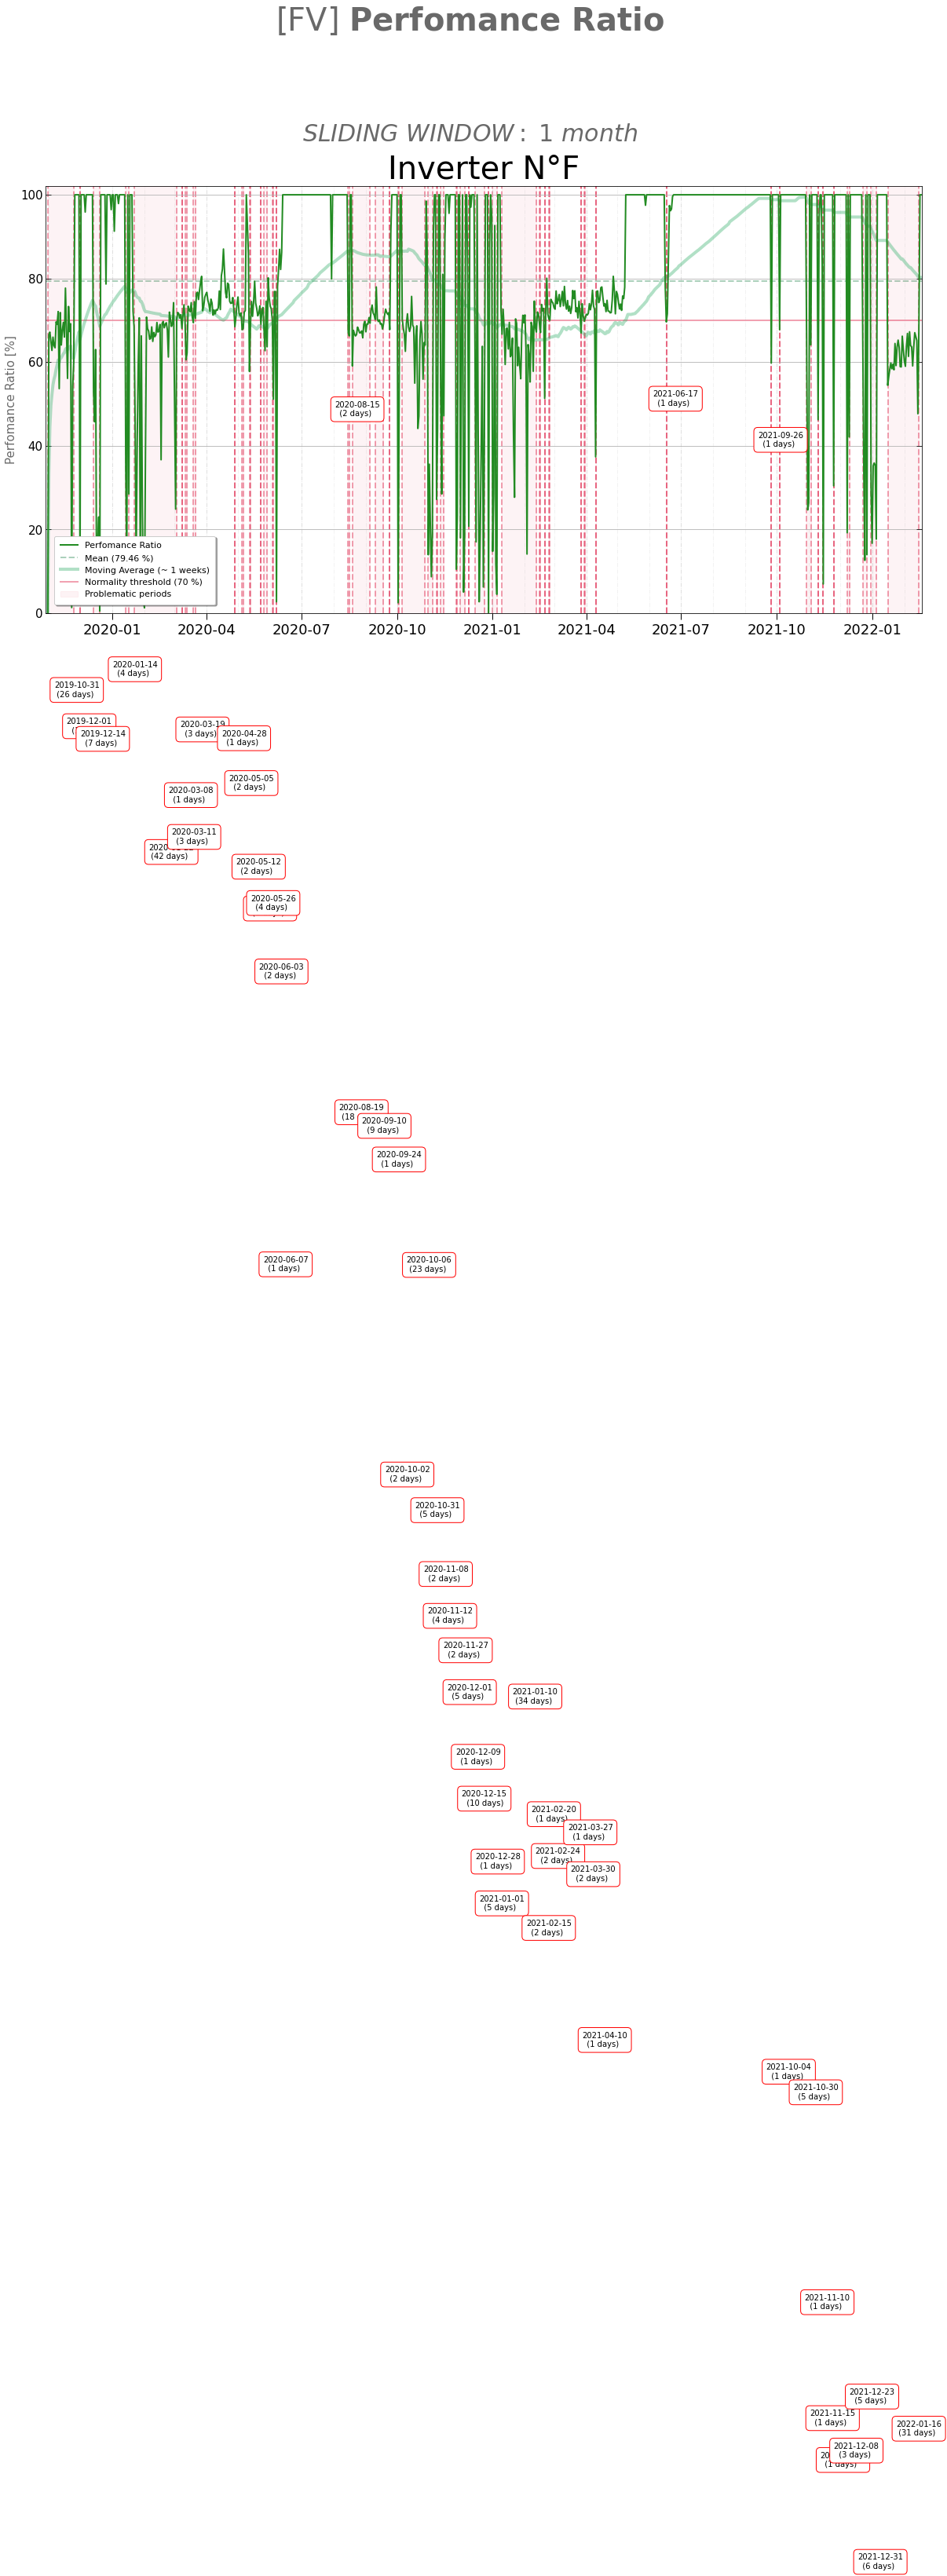

In [35]:
n_col = 1
n_row = len(inv_names) // n_col

# Retrieve the sliding window type to create the subtitle of the graphical pane
if sliding_window > 0:
    sub_title = r"$\it{SLIDING WINDOW: " + str(sliding_window) + " month" + ('s' if sliding_window > 1 else '') + r"}$"
    sub_title = sub_title.replace(' ', '\\ ')
else:
    sub_title = 'Cumulative'

# Create the Graphical panel 
fig, axes = plt.subplots(n_row, n_col, figsize= (20 * n_col, 10 * n_row), facecolor = "white")

axes = np.array([axes])

# Figure title
fig.suptitle(f"[{system_name.upper()}] " + r"$\bf{" + "Perfomance Ratio".replace(" ", "\\ ") + "}$", 
             fontsize = 40, color = "dimgray", y = 1.20)
fig.supxlabel(sub_title,  fontsize = 30, color = "dimgray", y = 0.9 if n_row == 2 else 0.952) #y = 

# Generate an historical graph for each inverter
idk_column = 0
idk_row = 0
inv_periods_below_thresholds = dict()

    
# Selecting the sub-graph 
graph = axes[0]

# Generate the graph
period_below_thresholds = diagnostic_utils.generate_historicalGraphs(perfomance_ratio_df, graph, system_name[0], normality_threshold, 
                                                                     plot_moving_average_lines = True, 
                                                                     visualize_under_threshold_period = True)
#inv_periods_below_thresholds[inv_name] = period_below_thresholds
    
    # Increment the row/column counters
#    if idk_column + 1 < axes.shape[1]:
#        idk_column += 1
#    else:
#        idk_column = 0
#        idk_row += 1
        
# Save the graphical panel  (as a png image) 
if sliding_window == -1:
    file_name = f"{system_name.replace(' ', '')}_perfomance_ratio_cumulative.png"
else:
    file_name = f"{system_name.replace(' ', '')}_perfomance_ratio_{sliding_window}month.png"
fig.tight_layout(pad = 4)
fig.savefig(path.join(saving_path, subfolders[0], file_name), bbox_inches='tight', pad_inches = 1)

# Visualize the graphical panel
fig.show()

# F) Performance Ratio with temperature correction

## F.1) Set Sliding window [months]
1. Number of months
2. Cumulative [-1]

In [27]:
sliding_window = 1

## F.2) Compute the *daily* Perfomance Ratio with temperature correction using a sliding window

In [28]:
verbose = False

In [29]:
inv_perfomance_ratio = dict()

# Isolate the dates
all_df_dates = sorted(set(df.index.date))
print(f"DATE AVAIABLE: {len(all_df_dates)}")
print(f"SELECTED PERIOD: {sliding_window} month(s)\n" +"-" * 40)

#display(df['2019-09-29':].head(50))

daily_perfomance_ratio = dict()
for idk, day in enumerate(all_df_dates):
    module_temp = diagnostic_utils.compute_module_temp(df, all_df_dates, day, sliding_window, verbose = False)
    daily_ratio = diagnostic_utils.compute_perfomance_ratios_temp_correction(df, all_df_dates, day, sliding_window, inverter_nominal_power, beta, module_temp, verbose = False)

    # Try to use the previous KPI value (if available) in case of None value
    if daily_ratio == None:
        prev_day = all_df_dates[idk - 1]

        if str(prev_day) in daily_perfomance_ratio.keys():
            prev_kpi = daily_perfomance_ratio[str(prev_day)]
            daily_ratio = prev_kpi

            #print(f"[FIXED] Replaced the missing value with: {prev_day} "\
                  #f"--> KPI: {round(prev_kpi['Perfomance Ratio (%)'], 2)} %")

    # Save the value only if it's available
    if daily_ratio:
        daily_perfomance_ratio[str(day)] = daily_ratio

# Create and save a dataframe for each inverter
perfomance_ratio_df = pd.DataFrame.from_dict(daily_perfomance_ratio, orient = "index")

# Carry out some transformation
perfomance_ratio_df["Generated energy (kWh)"] = perfomance_ratio_df["Generated energy (kWh)"] / 10 ** 3
perfomance_ratio_df["Summed Solar Irradiance (Wh/mq)"] = perfomance_ratio_df["Summed Solar Irradiance (Wh/mq)"] / 10 ** 3
perfomance_ratio_df.rename(columns = {"Generated energy (kWh)": "Generated energy (MWh)",
                                      "Summed Solar Irradiance (Wh/mq)" : "Summed Solar Irradiance (kWh/mq)"}, 
                           inplace = True)
#display(perfomance_ratio_df)

#x = inv_perfomance_ratio[inv_names[0]].head(50)
#display(x)

DATE AVAIABLE: 835
SELECTED PERIOD: 1 month(s)
----------------------------------------


../_library/diagnostic_utils.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_sliding_window["Irradiance (Wh/mq)"] = obs_sliding_window["Irradiance (W/mq)"] * 1 # hour
../_library/diagnostic_utils.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_sliding_window["Irradiance (Wh/mq)"] = obs_sliding_window["Irradiance (W/mq)"] * 1 # hour
../_library/diagnostic_utils.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

## F.3) Visualize potential problematic ratios

In [30]:
pr_col_name = "Perfomance Ratio (%)"

# ISSUE: Perfomance Ratio values excedding 100%
cond = perfomance_ratio_df[pr_col_name] > 100
invalid_scores = perfomance_ratio_df.loc[cond, :]
if len(invalid_scores) > 0:
    print(f"ISSUE: There are {len(invalid_scores)} observations ({round((len(invalid_scores)/len(perfomance_ratio_df))*100, 2)} %) "\
          "which have their PERFOMANCE RATIO EXCEEDING 100%\n" + "-" * 96)

    verbose = True
    for idk, outlier_ts in enumerate(invalid_scores.index): #[:50]
        print(f"\n\tOBSERVATION ({idk + 1}/{len(invalid_scores)}): {outlier_ts}\n\t" + "-" * 41)

        observation = invalid_scores.loc[outlier_ts, :]

        if verbose:
            for col_name, value in observation.to_dict().items():
                name_parts = col_name.split("(")
                if len(name_parts) == 2:
                    print(f"\t{name_parts[0].strip()}: {round(value, 2)} {name_parts[1][:-1]}")
                else:
                    print(f"\t{col_name}: {value}")

        # Stat: set it to the maxium value (100%)
        perfomance_ratio_df.loc[outlier_ts, pr_col_name] = 100
        print("\n\t" + "-" * 50 + "\n\tSTRAT: Setting this outliert to theorethical maxiumum (i.e., 100%).\n" 
              + "-" * 50 + "\n")
else:
    print("There aren't observations with thier perfomance ratio exceeding 100%. That's fantastic!\n"\
          f"\nDaily perfomance ratio available: {len(perfomance_ratio_df)} days")

ISSUE: There are 391 observations (48.57 %) which have their PERFOMANCE RATIO EXCEEDING 100%
------------------------------------------------------------------------------------------------

	OBSERVATION (1/391): 2019-12-09
	-----------------------------------------
	Starting Date: 2019-11-09
	Generated energy: 2.67 MWh
	Summed Solar Irradiance: 32.18 kWh/mq
	Perfomance Ratio: 105.34 %
	Sliding window: 1 months

	--------------------------------------------------
	STRAT: Setting this outliert to theorethical maxiumum (i.e., 100%).
--------------------------------------------------


	OBSERVATION (2/391): 2019-12-10
	-----------------------------------------
	Starting Date: 2019-11-10
	Generated energy: 2.76 MWh
	Summed Solar Irradiance: 31.46 kWh/mq
	Perfomance Ratio: 110.94 %
	Sliding window: 1 months

	--------------------------------------------------
	STRAT: Setting this outliert to theorethical maxiumum (i.e., 100%).
--------------------------------------------------


	OBSERVATIO

# G) GRAPH: Performance Ratio with temperature correction (temporal trend)

## G.0) Create the saving folder

In [31]:
system_path = 'data/unige/'
folder_name = "Diagnostic"
saving_path = path.join(system_path, folder_name)

if not path.exists(saving_path):
    makedirs(saving_path)
    print(f"The folder: {'folder_name'} has been created.")
else:
    print(f"The folder '{folder_name}' already exists. That's nice.")
    
subfolders = ["Perfomance Ratio with temperature correction", "Correlation"]
for subfolder in subfolders:
    if not path.exists(path.join(saving_path, subfolder)):
        makedirs(path.join(saving_path, subfolder))
        print(f"The folder: {'subfolder'} has been created.")
    else:
        print(f"The folder '{subfolder}' already exists. That's nice.")

The folder 'Diagnostic' already exists. That's nice.
The folder 'Perfomance Ratio with temperature correction' already exists. That's nice.
The folder 'Correlation' already exists. That's nice.


## G.1) Save the performance ratio with temperature correction

In [32]:
sub_folder = "Raw scores"
score_folder_path = path.join(saving_path, subfolders[0], sub_folder)
    
if not path.exists(score_folder_path):
    makedirs(score_folder_path)
    print(f"The folder: '{sub_folder}' has been created.")
else:
    print(f"The folder '{sub_folder}' already exists. That's nice.")

The folder 'Raw scores' already exists. That's nice.


In [33]:
for inv_name in inv_perfomance_ratio.keys():
    df = inv_perfomance_ratio[inv_name]

    file_name = f"{system_name.replace(' ', '')}_{inv_name.upper()}_perfomanceScores_"\
                f"{str(sliding_window) + 'month' if sliding_window != -1 else 'cumulative'}.csv"
    path_file = path.join(score_folder_path, file_name)
    
    df.to_csv(path_file, index = False)
    print(f"Perfomance ratio scores have been saved as '{file_name}'")

## G.2) Plot the historical trend of the 'Perfomance ratio with temperature correction'

In [34]:
normality_threshold = 70

../_library/diagnostic_utils.py:416: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perfomance_ratio_values = perfomance_ratio_values.append(new_artificial_data)
../_library/diagnostic_utils.py:416: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perfomance_ratio_values = perfomance_ratio_values.append(new_artificial_data)
../_library/diagnostic_utils.py:416: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perfomance_ratio_values = perfomance_ratio_values.append(new_artificial_data)
../_library/diagnostic_utils.py:416: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perfomance_ratio_values = perfomance_ratio_values.append(new_artificial_da


------------------------- FV -------------------------
PERIOD 1: FROM '2020-01-31' TO '2020-03-22' (52 days)
PERIOD 2: FROM '2020-05-24' TO '2020-06-04' (12 days)
PERIOD 3: FROM '2020-06-07' TO '2020-06-09' (3 days)
PERIOD 4: FROM '2020-09-13' TO '2020-09-26' (14 days)
PERIOD 5: FROM '2020-11-01' TO '2020-11-21' (21 days)
PERIOD 6: FROM '2021-01-13' TO '2021-01-19' (7 days)
PERIOD 7: FROM '2021-01-26' TO '2021-02-26' (32 days)
PERIOD 8: FROM '2022-02-11' TO '2022-02-17' (7 days)


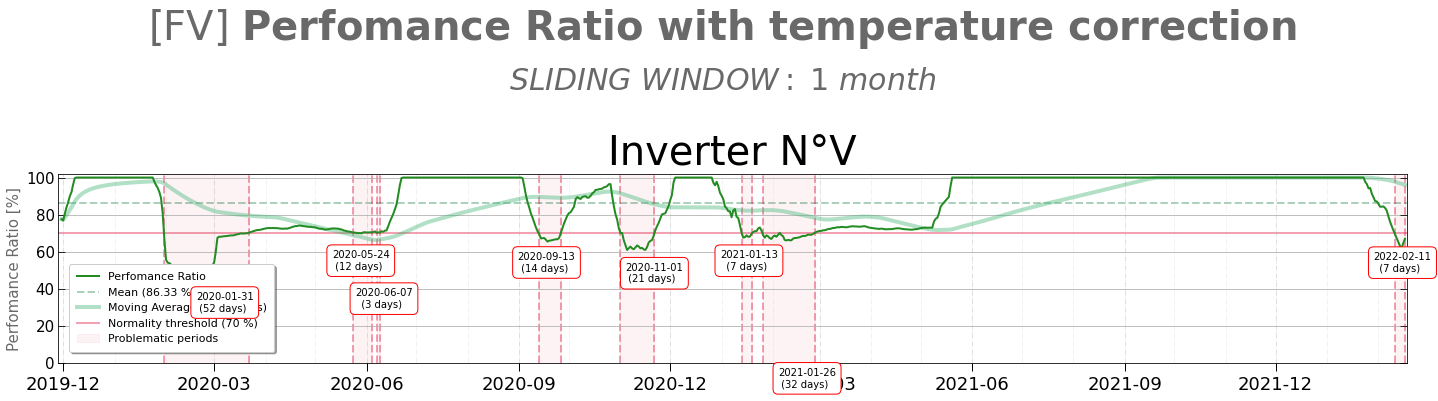

In [35]:
n_col = 1
n_row = len(inv_names) // n_col

# Retrieve the sliding window type to create the subtitle of the graphical pane
if sliding_window > 0:
    sub_title = r"$\it{SLIDING WINDOW: " + str(sliding_window) + " month" + ('s' if sliding_window > 1 else '') + r"}$"
    sub_title = sub_title.replace(' ', '\\ ')
else:
    sub_title = 'Cumulative'

# Create the Graphical panel 
fig, axes = plt.subplots(n_row, n_col, figsize= (20 * n_col, 5 * n_row), facecolor = "white")

axes = np.array([axes])

# Figure title
fig.suptitle(f"[{system_name.upper()}] " + r"$\bf{" + "Perfomance Ratio with temperature correction".replace(" ", "\\ ") + "}$", 
             fontsize = 40, color = "dimgray", y = 1.20)
fig.supxlabel(sub_title,  fontsize = 30, color = "dimgray", y = 0.9 if n_row == 2 else 0.952) #y = 

# Generate an historical graph for each inverter
idk_column = 0
idk_row = 0
inv_periods_below_thresholds = dict()

    
# Selecting the sub-graph 
graph = axes[0]

# Generate the graph
period_below_thresholds = diagnostic_utils.generate_historicalGraphs(perfomance_ratio_df, graph, 'FV', normality_threshold, 
                                                                     plot_moving_average_lines = True, 
                                                                     visualize_under_threshold_period = True)
#inv_periods_below_thresholds[inv_name] = period_below_thresholds
    
    # Increment the row/column counters
#    if idk_column + 1 < axes.shape[1]:
#        idk_column += 1
#    else:
#        idk_column = 0
#        idk_row += 1
        
# Save the graphical panel  (as a png image) 
if sliding_window == -1:
    file_name = f"{system_name.replace(' ', '')}_perfomance_ratio_with_temperature_correction_cumulative.png"
else:
    file_name = f"{system_name.replace(' ', '')}_perfomance_ratio_with_temperature_correction_{sliding_window}month.png"
fig.tight_layout(pad = 0.5)
fig.savefig(path.join(saving_path, subfolders[0], file_name), bbox_inches='tight', pad_inches = 1)

# Visualize the graphical panel
fig.show()